In [21]:
import ira
from ira.datasource import DataSource 
from os.path import join
import os
import json
from tqdm.auto import tqdm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from collections import defaultdict

%alphalab dark

from utils import load_ohlc

In [25]:
norm = lambda xs: xs / xs.iloc[0]
TFrame = '15Min'

In [26]:
md = load_ohlc('1Min', '2022-06-01', '2022-07-05')

In [27]:
closes = retain_columns_and_join(ohlc_resample(md, TFrame), 'close').ffill()

In [28]:
closes.head()

,AAVEUSDT,ADAUSDT,ALGOUSDT,ALPHAUSDT,AMPLUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BALUSDT,BANDUSDT,...,XEMUSDT,XLMUSDT,XMRUSDT,XRPUSDT,XTZUSDT,YFIIUSDT,YFIUSDT,ZECUSDT,ZILUSDT,ZRXUSDT
time,,,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,112.830,0.616565,0.41445,0.166725,0.96455,10.23025,26.3450,23.0505,7.47875,1.8075,...,0.053075,0.148487,197.630,0.420588,2.07360,529.250,8045.0,92.950,0.05411,0.426125
2022-06-01 00:15:00,114.415,0.620720,0.41605,0.165425,0.96475,10.25250,26.5130,22.9045,7.49625,1.7860,...,0.053525,0.147600,197.495,0.419600,2.08120,532.250,8080.0,92.465,0.05387,0.424875
2022-06-01 00:30:00,115.180,0.623103,0.41700,0.166950,0.96445,10.29075,26.7575,22.8675,7.54375,1.8045,...,0.054125,0.148150,198.960,0.422000,2.10065,536.875,8147.5,94.035,0.05416,0.425750
2022-06-01 00:45:00,115.740,0.628972,0.42150,0.169375,0.96450,10.42050,26.9125,22.9015,7.57750,1.8285,...,0.053875,0.148712,200.240,0.424963,2.11475,539.125,8155.0,94.905,0.05445,0.428750
2022-06-01 01:00:00,114.760,0.624270,0.42015,0.168450,0.96510,10.36975,26.8300,22.7305,7.46250,1.8110,...,0.053675,0.147062,199.490,0.423775,2.10785,539.625,8120.0,94.570,0.05408,0.429250


In [29]:
n_closes = closes.div(closes.iloc[0])

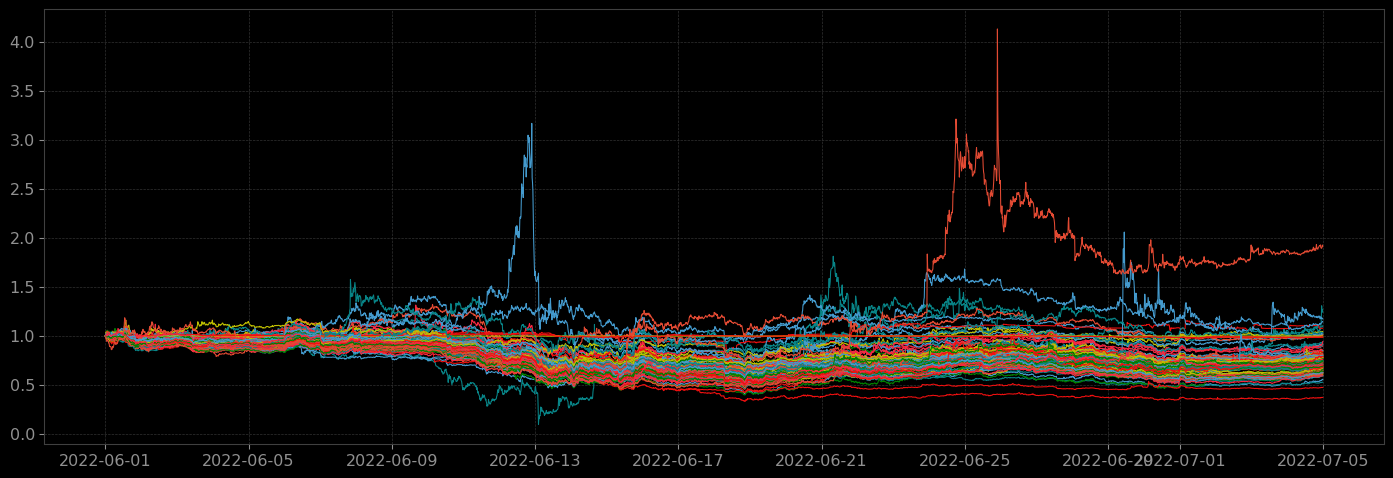

In [30]:
fig(18, 6)
plt.plot(n_closes);

In [31]:
xtrain, xtest = train_test_split(closes, test_size=0.25, shuffle=False)

In [32]:
def find_coint_table(xs: pd.DataFrame):
    syms = xs.columns
    nsyms = len(syms)
    pvals = defaultdict(dict)
    for i1 in tqdm(range(nsyms - 1)):
        for i2 in range(i1 + 1, nsyms):
            cres = sm.tsa.stattools.coint(xs.iloc[:, i1], xs.iloc[:, i2])
            pvals[syms[i1]][syms[i2]] = cres[1]
    return pd.DataFrame(pvals)

Co-integrating prices

In [33]:
ctable = find_coint_table(xtrain)

In [36]:
ctable

,AAVEUSDT,ADAUSDT,ALGOUSDT,ALPHAUSDT,AMPLUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BALUSDT,BANDUSDT,...,XAUTUSDT,XEMUSDT,XLMUSDT,XMRUSDT,XRPUSDT,XTZUSDT,YFIIUSDT,YFIUSDT,ZECUSDT,ZILUSDT
ADAUSDT,0.629634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALGOUSDT,0.576079,0.300013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALPHAUSDT,0.825249,0.217417,0.044212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMPLUSDT,0.243735,0.006363,0.092133,0.029811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATOMUSDT,0.909883,0.721719,0.540466,0.726229,0.505015,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YFIIUSDT,0.661755,0.574273,0.676675,0.631497,0.819664,0.521041,0.642790,0.493763,0.792302,0.350579,...,0.128711,5.780832e-01,0.667998,0.820098,0.617387,0.765360,NaN,NaN,NaN,NaN
YFIUSDT,0.784843,0.421934,0.053108,0.079698,0.359250,0.023068,0.007460,0.017151,0.591834,0.035143,...,0.216949,1.908874e-01,0.071420,0.837174,0.000022,0.839289,0.993689,NaN,NaN,NaN
ZECUSDT,0.559313,0.074881,0.287287,0.326867,0.114441,0.893502,0.714723,0.549740,0.231462,0.053072,...,0.097963,9.292531e-02,0.473111,0.089480,0.629826,0.087998,0.990911,0.849899,NaN,NaN
ZILUSDT,0.979325,0.770588,0.573959,0.721033,0.689863,0.034475,0.291241,0.113133,0.887739,0.188764,...,0.268342,5.329765e-01,0.535776,0.966239,0.296071,0.954771,0.991747,0.025329,0.973715,NaN


In [37]:
ctable[ctable <= 0.05]

,AAVEUSDT,ADAUSDT,ALGOUSDT,ALPHAUSDT,AMPLUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BALUSDT,BANDUSDT,...,XAUTUSDT,XEMUSDT,XLMUSDT,XMRUSDT,XRPUSDT,XTZUSDT,YFIIUSDT,YFIUSDT,ZECUSDT,ZILUSDT
ADAUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALGOUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALPHAUSDT,NaN,NaN,0.044212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMPLUSDT,NaN,0.006363,NaN,0.029811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATOMUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YFIIUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YFIUSDT,NaN,NaN,NaN,NaN,NaN,0.023068,0.00746,0.017151,NaN,0.035143,...,NaN,NaN,NaN,NaN,0.000022,NaN,NaN,NaN,NaN,NaN
ZECUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZILUSDT,NaN,NaN,NaN,NaN,NaN,0.034475,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025329,NaN,NaN


In [39]:
coints = ctable.stack().loc[lambda f: f <= 0.05].rename_axis(['Symbol1', 'Symbol2'])

In [40]:
coint_pairs = {}
for i, ci in zip(coints.index, coints):
    print(f"{i[0]:10s}| {i[1]:10s}  -> {ci}")
    coint_pairs[f"{i[0]},{i[1]}"] = ci

ALPHAUSDT | ALGOUSDT    -> 0.04421189711930667
AMPLUSDT  | ADAUSDT     -> 0.006363145132563171
AMPLUSDT  | ALPHAUSDT   -> 0.029811239734956436
AVAXUSDT  | ALGOUSDT    -> 0.0057209322058213346
AVAXUSDT  | ALPHAUSDT   -> 0.03081683562404716
BALUSDT   | ADAUSDT     -> 0.023684530028378864
BALUSDT   | ALGOUSDT    -> 0.043145089505873306
BALUSDT   | AMPLUSDT    -> 0.00817878294633404
BNBUSDT   | BANDUSDT    -> 0.04588272438466195
BTTUSDT   | BANDUSDT    -> 0.044160883126195656
BTTUSDT   | BNBUSDT     -> 0.037072347556794304
CELOUSDT  | AAVEUSDT    -> 0.018844886252636212
CELOUSDT  | BTTUSDT     -> 0.03434247595220749
CELUSDT   | BSVUSDT     -> 0.03519766086973086
CHZUSDT   | AAVEUSDT    -> 0.007967918867855242
CHZUSDT   | AXSUSDT     -> 0.00768940018949894
CHZUSDT   | BTTUSDT     -> 0.03786035895195317
CHZUSDT   | CELOUSDT    -> 0.002467859223032833
COMPUSDT  | ATOMUSDT    -> 0.03668164989034438
CROUSDT   | BTTUSDT     -> 0.00881778722946149
CROUSDT   | CELOUSDT    -> 0.042542319507053374
C

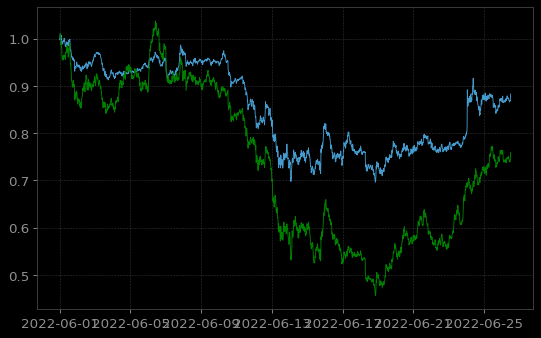

In [41]:
plt.plot(norm(xtrain[['XRPUSDT', 'RUNEUSDT']]))

Store found cointegrated pairs into file

In [43]:
with open(f'coint_pairs_{TFrame}.json', 'w') as f:
    # start / end of train period
    s0, e0 = xtrain.index[[0, -1]]
    json.dump({
        'pairs': coint_pairs,
        'timeframe': TFrame,
        'start': str(s0),
        'end': str(e0),
    }, f)